## This is my practice tutorial for the final project

## Here we will use the astropy as our fits reader

In [44]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

## Here we will open our FITS file

In [76]:
fname = "image.fits"
hdu_list = fits.open(fname)
hdu_list.info()

Filename: image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     337   (256, 256)   int16 (rescales to float32)   


## Gather information from the PRIMARY block using hdu_list

In [46]:
image_data = hdu_list[0].data

## To gather dimensions of the image we will look at the shape of the array

In [47]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(256, 256)


## Close the FITS file, everything was stored to a variable

In [48]:
hdu_list.close()

## A shortcut [getdata()] to just read in the image data and close the file

In [49]:
image_data = fits.getdata(fname)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(256, 256)


## Show the image

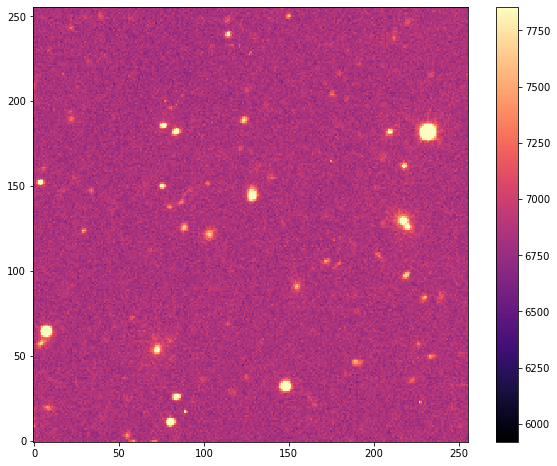

In [50]:
m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation='nearest', cmap='magma', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

## Subtract the background data before sources can be detected with separate steps

In [63]:
# measure a spatially varying background on the image
bkg = sep.Background(image_data)

## Basic statistics about our image:

In [59]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: 6566.26
Max: 98214.56
Mean: 6887.266
Stdev: 966.7967


## Control the box size

In [64]:
bkg = sep.Background(image_data)

In [65]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


In [67]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

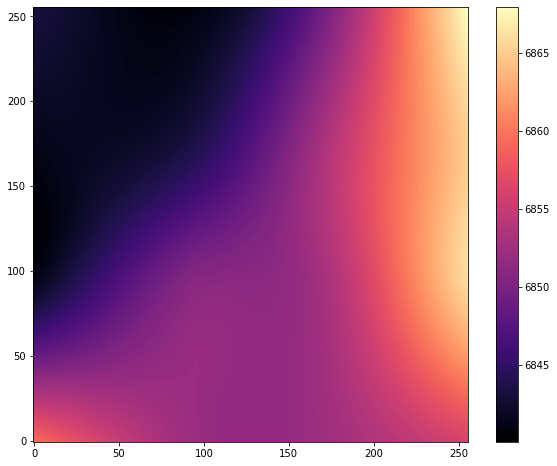

In [69]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='magma', origin='lower')
plt.colorbar();

In [70]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

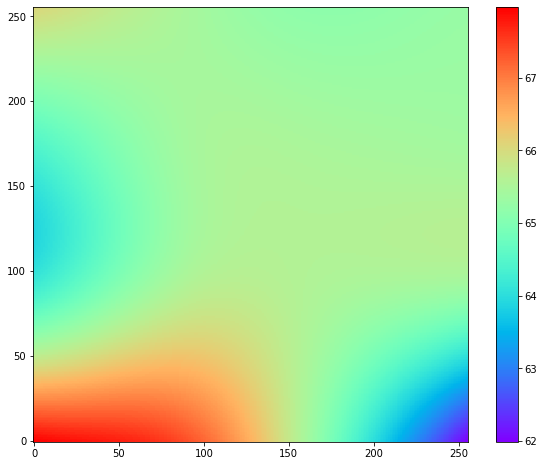

In [87]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='rainbow', origin='lower')
plt.colorbar();

In [73]:
# subtract the background
data_sub = image_data - bkg

## Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of 1.5σ where σ is the global background RMS.

In [99]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

#sep.extract has many options for controlling detection threshold, pixel masking, filtering, and object deblending.

In [77]:
# how many objects were detected
len(objects)

68

## objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we’ll over-plot the object coordinates with some basic shape parameters on the image

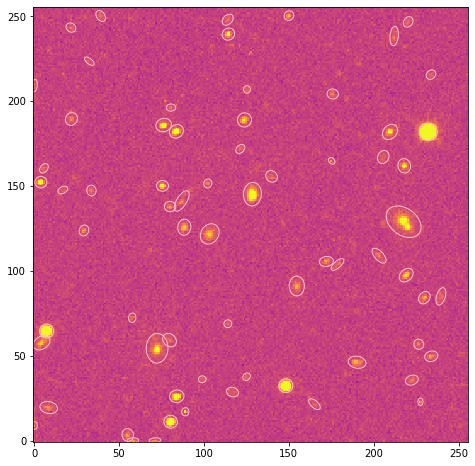

In [98]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='plasma',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('pink')
    ax.add_artist(e)

## objects has many fields, gives information such as second moments,peak pixel position and values

In [83]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## We’ll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects

In [84]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)


In [85]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 3092.220430 +/- 291.592204
object 2: flux = 5949.868379 +/- 356.562003
object 3: flux = 1851.426582 +/- 295.028816
object 4: flux = 72736.386914 +/- 440.172206
object 5: flux = 3860.756152 +/- 352.163162
object 6: flux = 6418.913789 +/- 357.458973
object 7: flux = 2210.707656 +/- 350.791223
object 8: flux = 2741.607227 +/- 352.277746
object 9: flux = 20916.875566 +/- 376.966138
